In [5]:
## Calculating Cl and Cd for Various Rocket Fins" ##

'''
Fin types:
- Canard -> a trapezoidal fin shape with a protruding shaft for canard actuation
- Trapezoidal -> a typical trapeziodal fin used in first stage rockets
- Swept -> a typical swept fin used in first stage rockets

'''

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as m
import os
from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity

In [6]:
# File Imports #

files = [
    ['BlackRPM200AOA05.csv','BlackRPM300AOA05.csv','BlackRPM400AOA05.csv','BlackRPM500AOA05.csv'],
    ['BlueRPM200AOA05.csv','BlueRPM300AOA05.csv','BlueRPM400AOA05.csv','BlueRPM500AOA05.csv'],
    ['WhiteRPM200AOA05.csv','WhiteRPM300AOA05.csv','WhiteRPM400AOA05.csv','WhiteRPM500AOA05.csv']
]

folder = 'Lab3_Renamed'

In [7]:
# Constants and Config Settings #

fin_types = [ 
    # Matching the fin type to the corresponding data file
    'Canard', # Black
    'Trapezoidal', # Blue
    'Swept' # White
]

planform_area = [    
    # NEED MORE PRECISE NUMBERS FOR CANARD AND SWEPT FIN
    38.38, # Canard 
    38.07, # Trapezoidal
    38.91  # White
] # in^2

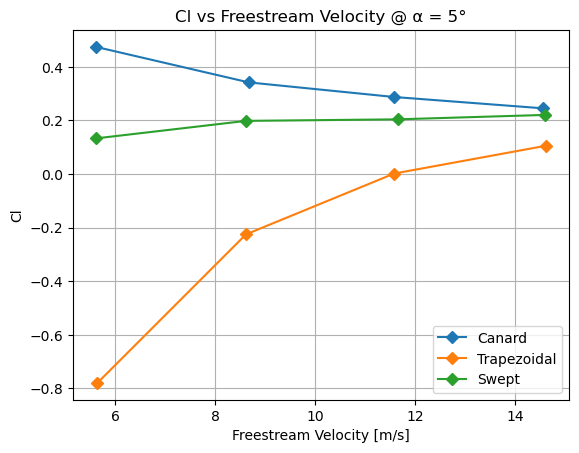

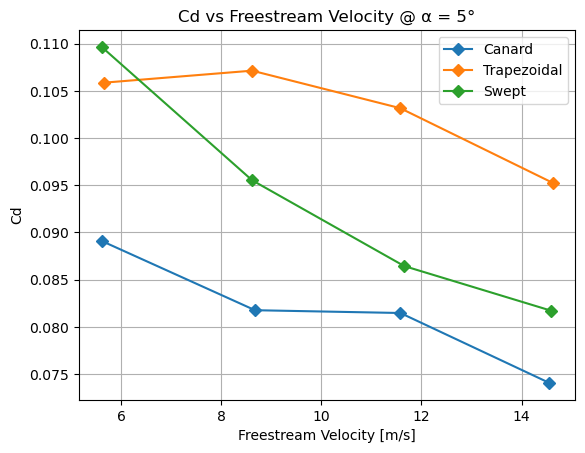

In [ ]:
# Calculate and Plot #

Cl = np.zeros((len(files), len(files[0])))
Cd = np.zeros((len(files), len(files[0])))
Cl_std = np.zeros((len(files), len(files[0])))
Cd_std = np.zeros((len(files), len(files[0])))
U_inf = np.zeros((len(files), len(files[0])))

for i in range(len(files)):

    for j in range(len(files[i])):
        path = os.path.join(folder, files[i][j])
        df = pd.read_csv(path, encoding='latin-1', skiprows=[1])

        T = df['Temperature'].mean() + 273.15
        B = df['Barometric Pressure'].mean()
        phi = df['Humidity'].mean() / 100

        std_T = df['Temperature'].std()
        std_B = df['Barometric Pressure'].std()
        std_phi = df['Humidity'].std() / 100 #
        std_U = df['Velocity'].std()
        std_F_normal = df['PGB Normal'].std()
        std_F_axial = df['PGB Axial'].std() 

        density = (1 / T) * (
            (B / 287.05) - 
            phi * (2.05*10**(-5)) * (m.e**(0.0631846 * T)) * 
            ((1/287.05) - (1/461.05))
        ) # kg/m^3 mean density

        # for density uncertainty
        dRho_dB   = 1 / (287.05 * T)
        dRho_dPhi = -( (2.05*10**(-5) * m.e**(0.0631846 * T)) /T) * ((1/287.05) - (1/461.05))
        dPw_dT    = 0.0631846 * (2.05*10**(-5) * m.e**(0.0631846 * T))
        dRho_dT   = -(1/T**2) * ( (B/287.05) - (phi * (2.05*10**(-5) * m.e**(0.0631846 * T)) * ((1/287.05)-(1/461.05))) ) - (phi/T) * dPw_dT * ((1/287.05) - (1/461.05))

        std_rho =  m.sqrt( (dRho_dT*std_T)**2 + (dRho_dB*std_B)**2 + (dRho_dPhi*std_phi)**2 )

        U_inf[i][j] = df['Velocity'].mean() # m/s
        
        F_normal = df['PGB Normal'].mean() # N
        F_axial = df['PGB Axial'].mean() # N

        Cl[i][j] = F_normal / (0.5 * density * U_inf[i][j]**2 * Q_(planform_area[i], 'in^2').m_as('m^2'))
        Cd[i][j] = F_axial / (0.5 * density * U_inf[i][j]**2 * Q_(planform_area[i], 'in^2').m_as('m^2'))

        # for Cl and Cd uncertaintly 
        dCl_dF = 2 / (density * U_inf[i][j]**2 * Q_(planform_area[i], 'in^2').m_as('m^2'))
        dCl_dRho = -( (2*F_normal) / (density**2 * U_inf[i][j]**2 * Q_(planform_area[i], 'in^2').m_as('m^2')) )
        dCl_dV = -( F_normal / (density * U_inf[i][j]**3 * Q_(planform_area[i], 'in^2').m_as('m^2')) )
        Cl_std[i][j] = m.sqrt( (dCl_dF * std_F_normal)**2 + (dCl_dRho * std_rho)**2 + (dCl_dV * std_U)**2 )

        dCd_dF = 2 / (density * U_inf[i][j]**2 * Q_(planform_area[i], 'in^2').m_as('m^2'))
        dCd_dRho = -( (2*F_axial) / (density**2 * U_inf[i][j]**2 * Q_(planform_area[i], 'in^2').m_as('m^2')) )
        dCd_dV = -( F_axial / (density * U_inf[i][j]**3 * Q_(planform_area[i], 'in^2').m_as('m^2')) )
        Cd_std[i][j] = m.sqrt( (dCd_dF * std_F_axial)**2 + (dCd_dRho * std_rho)**2 + (dCd_dV * std_U)**2 )


# Plot Cl
for i in range(3):
    plt.errorbar(U_inf[i], Cl[i], yerr=Cl_std[i], marker='D', 
                 capsize=5, capthick=2, label=fin_types[i])

'''
for i in range(3):
    plt.plot(U_inf[i], Cl[i], marker='D', label=fin_types[i])
'''

plt.xlabel('Freestream Velocity [m/s]')
plt.ylabel('Cl')
plt.title(f'Cl vs Freestream Velocity @ α = 5°')

plt.grid(True)
plt.legend()
plt.show()


# Plot Cd

for i in range(3):
    plt.errorbar(U_inf[i], Cd[i], yerr=Cd_std[i], marker='D', 
                 capsize=5, capthick=2, label=fin_types[i])

'''
for i in range(3):
    plt.plot(U_inf[i], Cd[i], marker='D', label=fin_types[i])
'''
    
plt.xlabel('Freestream Velocity [m/s]')
plt.ylabel('Cd')
plt.title(f'Cd vs Freestream Velocity @ α = 5°')

plt.grid(True)
plt.legend()
plt.show()